Epoch #1


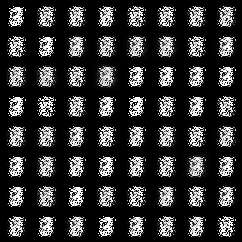



Epoch #2


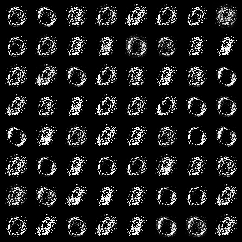



Epoch #3


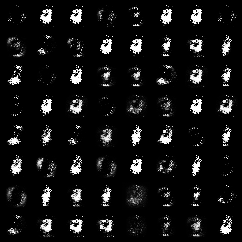



Epoch #4


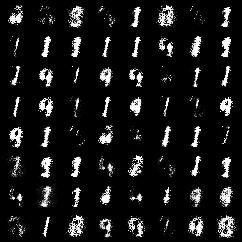



Epoch #5


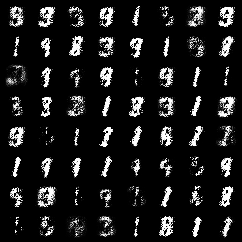



Epoch #6


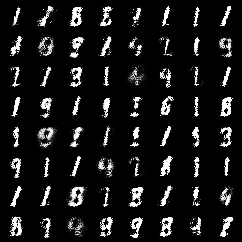



Epoch #7


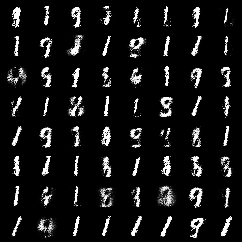



Epoch #8


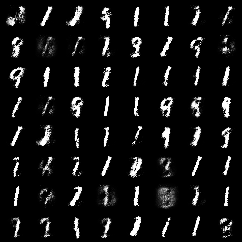



Epoch #9


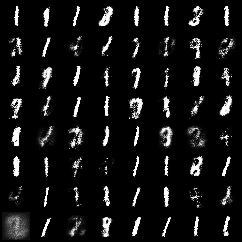



Epoch #10


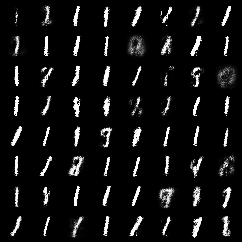



Epoch #11


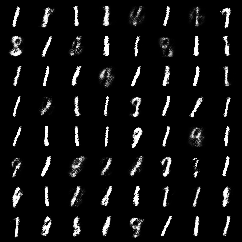



Epoch #12


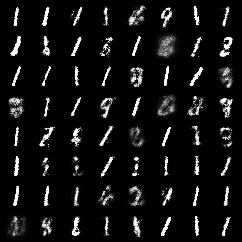



Epoch #13


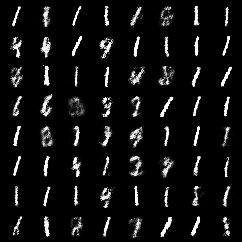



Epoch #14


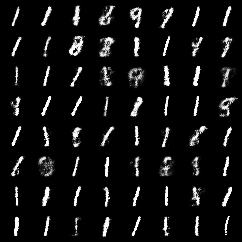



Epoch #15


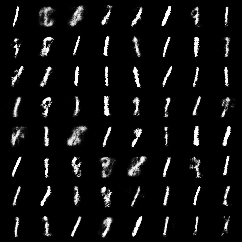



Epoch #16


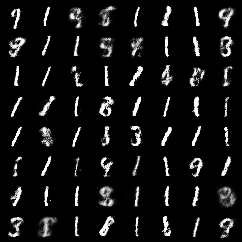



Epoch #17


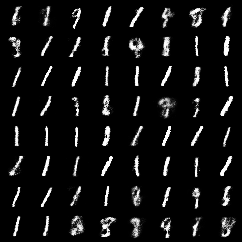



Epoch #18


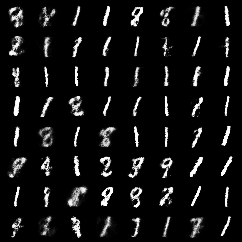



Epoch #19


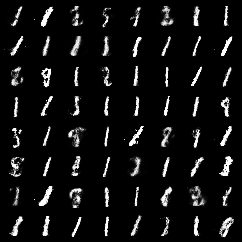



Epoch #20


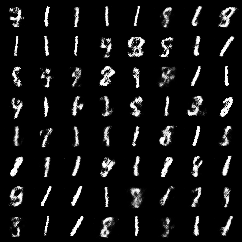



Epoch #21


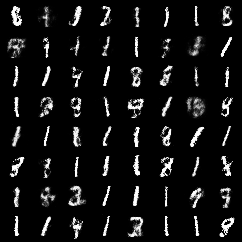



Epoch #22


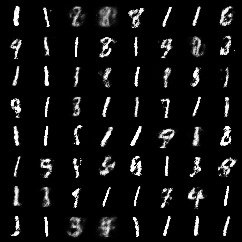



Epoch #23


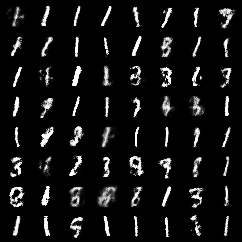



Epoch #24


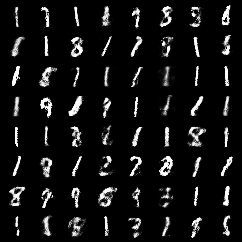



Epoch #25


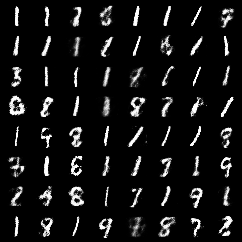



Epoch #26


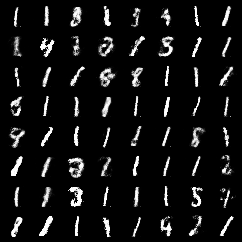



Epoch #27


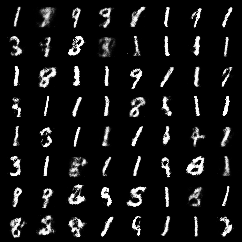



Epoch #28


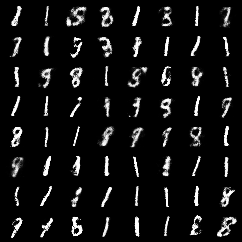



Epoch #29


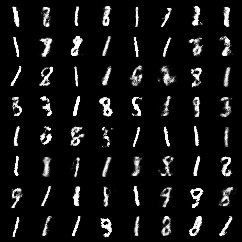



Epoch #30


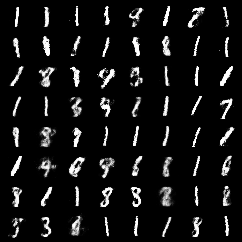



Epoch #31


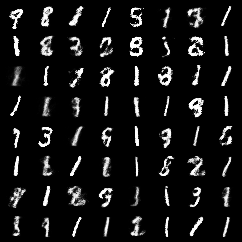



Epoch #32


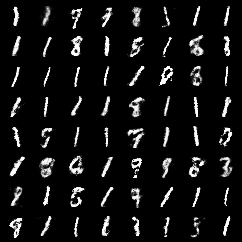



Epoch #33


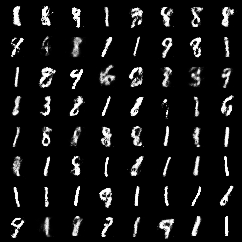



Epoch #34


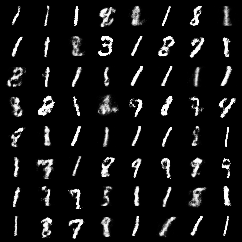



Epoch #35


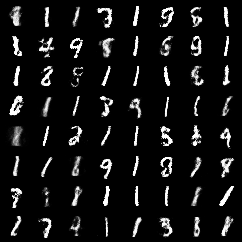



Epoch #36


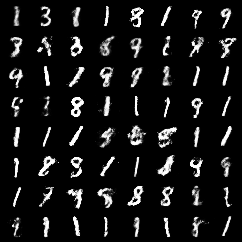



Epoch #37


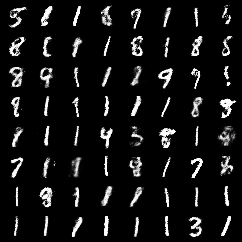



Epoch #38


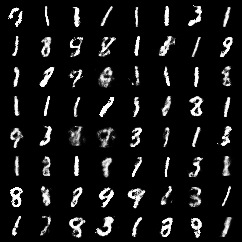



Epoch #39


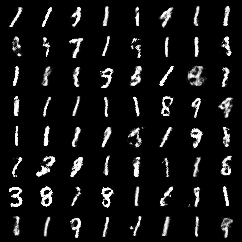



Epoch #40


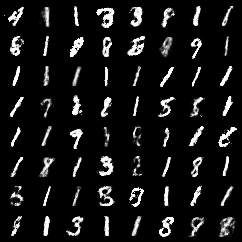



Epoch #41


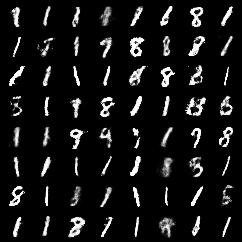



Epoch #42


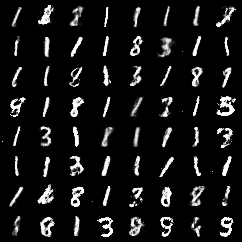



Epoch #43


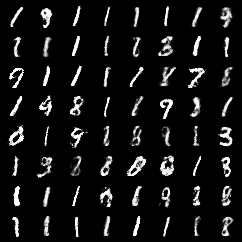



Epoch #44


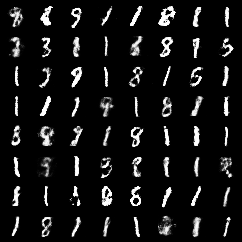



Epoch #45


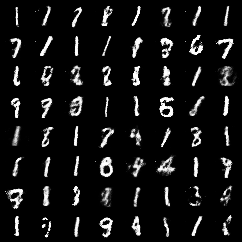



Epoch #46


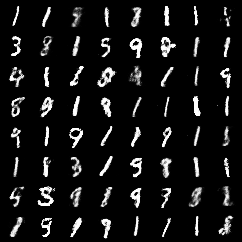



Epoch #47


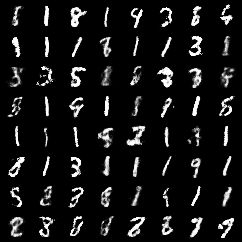



Epoch #48


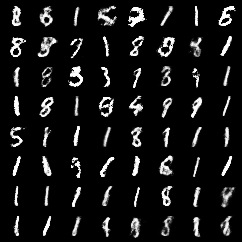



Epoch #49


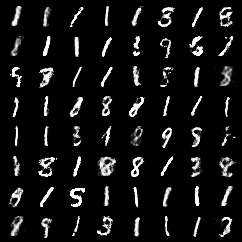



Epoch #50


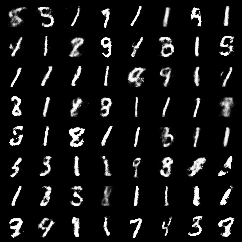

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os

if not os.path.exists('results'):
    os.mkdir('results')

batch_size = 100
latent_size = 20

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)


class Generator(nn.Module):
    #The generator takes an input of size latent_size, and will produce an output of size 784.
    #It should have a single hidden linear layer with 400 nodes using ReLU activations, and use Sigmoid activation for its outputs
    def __init__(self):
        super(Generator, self).__init__()
        H = 400
        D_out = 784
        self.layer1 = torch.nn.Linear(latent_size, H)
        self.layer2 = torch.nn.Linear(H, D_out)

    def forward(self, z):
        z = z.view(z.size(0), -1)
        z = F.relu(self.layer1(z))
        output = torch.sigmoid(self.layer2(z))
        return output

class Discriminator(nn.Module):
    #The discriminator takes an input of size 784, and will produce an output of size 1.
    #It should have a single hidden linear layer with 400 nodes using ReLU activations, and use Sigmoid activation for its output
    def __init__(self):
        super(Discriminator, self).__init__()
        D_in = 784
        H = 400
        D_out = 1
        self.layer1 = torch.nn.Linear(D_in, H)
        self.layer2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.layer1(x))
        output = torch.sigmoid(self.layer2(x))
        return output

real_label = 1.
fake_label = 0.
criterion = nn.BCELoss()

def train(generator, generator_optimizer, discriminator, discriminator_optimizer):
    #Trains both the generator and discriminator for one epoch on the training dataset.
    #Returns the average generator and discriminator loss (scalar values, use the binary cross-entropy appropriately)
    # For each batch in the dataloader
    total_generator_loss = 0
    total_discriminator_loss = 0
    iters = 0
    for i, data in enumerate(train_loader, 0):
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

        ## Train with all-real batch
        discriminator.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()

        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        discriminator_optimizer.step()

        # (2) Update G network: maximize log(D(G(z)))
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        errG.backward()

        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Save Losses for plotting later
        total_generator_loss += errG.item()
        total_discriminator_loss += errD.item()
        iters += 1

    avg_generator_loss = total_generator_loss/iters
    avg_discriminator_loss = total_discriminator_loss/iters
    return avg_generator_loss, avg_discriminator_loss

def test(generator, discriminator):
    #Runs both the generator and discriminator over the test dataset.
    #Returns the average generator and discriminator loss (scalar values, use the binary cross-entropy appropriately)
    total_generator_loss = 0
    total_discriminator_loss = 0
    iters = 0
    for i, data in enumerate(test_loader, 0):
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

        # Format batch
        real_cpu = data[0].to(device)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator(real_cpu).view(-1)
        errD_real = criterion(output, label)

        ## Test with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)

        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake


        # (2) Update G network: maximize log(D(G(z)))
        label.fill_(real_label)  # fake labels are real for generator cost
        # Perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)

        # Save Losses for plotting later
        total_generator_loss += errG.item()
        total_discriminator_loss += errD.item()
        iters += 1

    avg_generator_loss = total_generator_loss/iters
    avg_discriminator_loss = total_discriminator_loss/iters
    return avg_generator_loss, avg_discriminator_loss


epochs = 50

discriminator_avg_train_losses = []
discriminator_avg_test_losses = []
generator_avg_train_losses = []
generator_avg_test_losses = []

generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator_optimizer = optim.Adam(generator.parameters(), lr=1e-3)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    generator_avg_train_loss, discriminator_avg_train_loss = train(generator, generator_optimizer, discriminator, discriminator_optimizer)
    generator_avg_test_loss, discriminator_avg_test_loss = test(generator, discriminator)

    discriminator_avg_train_losses.append(discriminator_avg_train_loss)
    generator_avg_train_losses.append(generator_avg_train_loss)
    discriminator_avg_test_losses.append(discriminator_avg_test_loss)
    generator_avg_test_losses.append(generator_avg_test_loss)

    with torch.no_grad():
        sample = torch.randn(64, latent_size).to(device)
        sample = generator(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Epoch #' + str(epoch))
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

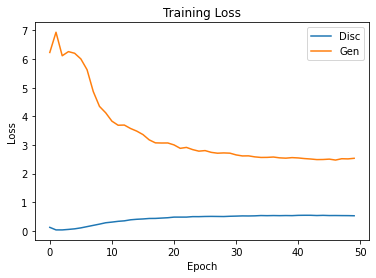

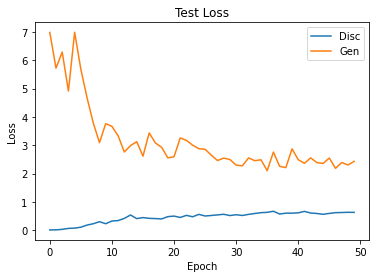

In [ ]:
plt.plot(discriminator_avg_train_losses)
plt.plot(generator_avg_train_losses)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Disc','Gen'], loc='upper right')
plt.show()

plt.plot(discriminator_avg_test_losses)
plt.plot(generator_avg_test_losses)
plt.title('Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Disc','Gen'], loc='upper right')
plt.show()
